# The Big Challenge

## Model Description 
This constructs a three-layer 2D steady state box model with a single stream
#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = 150 m       # the sketch in assignment materials shows max 125 m

#### Topography
- Bottom of the domain is flat, bottom layer is 40m thick
- Middle layer is also flat, and 5 m thick
- Top layer elevation is provided in BASE_TOP_ELEV_CSV

#### Subsurface Properties: 
- Homogeneous within each of three layers 
- K top and bottom layers = 8.5 m/day in x, y and z.
- K middle layer = same as top and bottom for leftmost 20 columns
- K middle layer: 0.0001 m/day in z direction for rightmost 30 columns 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001  

#### Stream Properties: 
- Inflow to first reach = 0 m3/d
- Streambed slope = 0.001 m/m
- Streambed rough = 0.04
- Streambed width = 1 m
- Streambed K = 1.36 x horizontal K of top layer
- Streambed thickness = 1 m
- Stream bottom depth = 2 m #to set stream 1 m below ground surface
- Stage = .5 m

#### Boundary Conditions: 
 - Right boundary for all layers is defined by a constant head of 70 m relative to the datum (located at bottom of domain).
 - Left, top, and bottom boundaries are no flow.

# Set up the environment

In [9]:
import flopy
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import flopy.utils.binaryfile as bf

%matplotlib inline

# User inputs

In [10]:
modelname = "NTNA" #No Town No Ag = steady state with no pumping from town well
moddir="C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe"
NTNA = flopy.modflow.Modflow(modelname, exe_name = moddir)

nlay = 3
nrow = 50
ncol = 50
dx = 10
dy = 10

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
zbot = 0.

dz = (ztop - zbot) / nlay  #cell height in z direction
Lx = dx*ncol
Ly = dy*nrow

K = 8.5 #m/day in x, y, and z


hright = 70 #m constant head right boundary

nper = 1
steady = [True]

# Setup layer properties

In [11]:
botm = np.zeros((nlay,nrow,ncol)) # array of zeros for bottom elevation for each layer (dim: nlay,nrow,ncol)
botm[0,:,:] = 45   # bottom elevation of top layer (0) is 45 m 
botm[1,:,:] = 40   # bottom elevation of middle layer (1) is 40 m

## Make a arrays for the K values
Khorz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Khorz[:,:,:] = K                       # assign the original value to the entire array
Khorz[1,:,:] = 0.0001                  # Replace the K in the middle layer with the lower value

Kvert = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kvert[:,:,:] = K                       # assign the original value to the entire array
Kvert[1,:,21:50] = 0.0001              # assign low K to rightmost 30 columns of middle layer 

Ss = 0.0001
Sy = 0.1 
n = 0.1
uncnf = 1  #unconfined aquifer
recharge = 4e-5  #m/day

#Create dis object
dis = flopy.modflow.ModflowDis(model=NTNA, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)   #Model unit meters (lenuni = 2) and days (itmuni = 4)

#Create bas object
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, -1] = -1   #right boundary of constant head
ibound[:,:,0] = 0       #left boundary of no flow
ibound[:,0,:] = 0       #top boundary of no flow
ibound[:,-1,:] = 0      #bottom boundary of no flow

#Bedrock Top Layer
ibound[:,0:5,0:5] = 0  #top no flow

#Bedrock Middle Layer
ibound[1,0:7,0:7] = 0  #middle no flow

#Bedrock Bottom Layer
ibound[2,0:9,0:9] = 0  #bottom no flow

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = hright    #initialize the entire domain to the right head value
bas = flopy.modflow.ModflowBas(NTNA, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(NTNA, laytyp=uncnf, hk=Khorz, 
                               vka=Kvert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[:,0:15] = recharge                    #recharge only occurs in 15 leftmost columns
rch = flopy.modflow.mfrch.ModflowRch(model=NTNA, rech=rech_zone, ipakcb=53)     #create rch object

#Evapotranspiration   
ET_zone = np.zeros((1,nrow,ncol))                 # define an array of zeroes the size of the model grid
rightET = 1e-5                                  #m/day in right half of domain
ripET = 5e-4                                    #m/day in riparian area 
ET_zone[20:-1,:] = rightET
ET_zone[:,21:29] = ripET
extinction_depth = 1 #m ET is zero when the water table is below this depth
evt = flopy.modflow.mfevt.ModflowEvt(model=NTNA, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 

#Wells
#Town Well



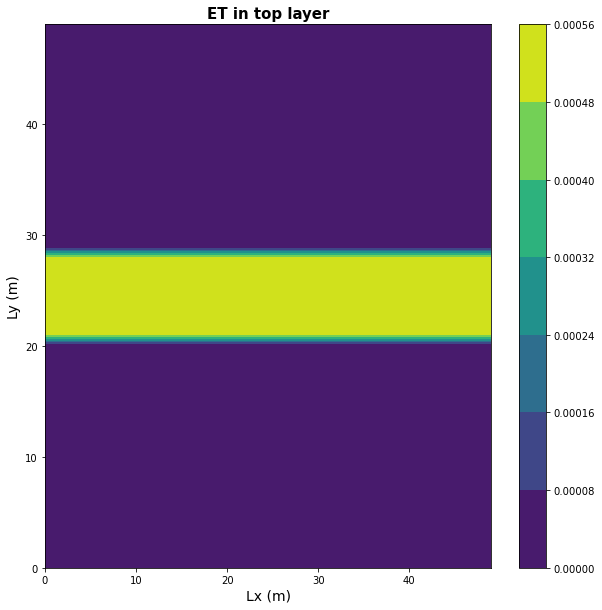

In [12]:
#plot ET values in top layer
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('ET in top layer', fontsize = 15, fontweight = 'bold')
plt.contourf(ET_zone[0,:,:])
plt.colorbar()
plt.show()

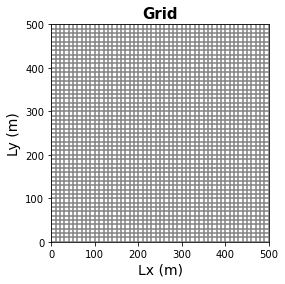

In [27]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=NTNA, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

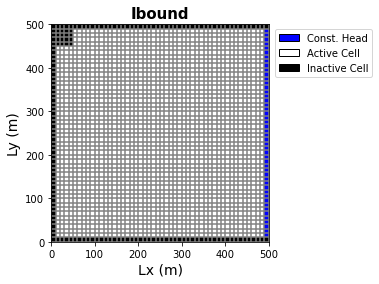

In [13]:
#Model Map
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=NTNA, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

In [3]:




strt = np.ones((nlay, nrow, ncol), dtype=np.float32)  
strt[:, 0:51, 0] = 9                 #create strt as array of floats 
strt[:, 0:51, -1] = np.linspace(10,3,51)                 #create strt as array of floats 

bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=1000, iter1=2000, relax = 0.7, damp = 0.7)

#LPF object
hk = np.ones((nlay,nrow,ncol), dtype=np.float32)      #defining conductivity in m/d
vk = np.ones((nlay,nrow,ncol), dtype=np.float32)

# vk = vk/10
# hk[:,0:25,:] = hk[:,0:25,:]*10
# vk = vk*10

ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage
ss[:,:,:] = 1e-5
n = 0.35
Sy = 0.3
uncnf = 1

lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=hk, 
                               vka=vk, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

# Rch object
recharge = 5e-5 #m/day
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[0:26,:]=rech_zone[0:26,:]+recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object

#create  output control object 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

C:\Users\tento\AppData\Local\Temp\ipykernel_8468\742110150.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage


# Setup the stream! Define STR object

In [4]:
# User inputs:
k_strbott = 1                      #river bottom hydraulic conductivity in f/d
sed_thick = 1                      #thickness of riverbed sediment in f
str_bott = 4                       #river bottom
slope = 0.0001                        #slope of streambed (m/m)
rough = 0.02377                         #roughness of streambed
width = 20.                           #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0    # m^3/day
Stage_above_datum = 8 # m/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# str settings
set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
str_spd1 = []                      #create list to store all river cells for stress period 1
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

# calculated values
cond = k_strbott*(dy)*(dx)/(sed_thick) #river bed conductance in f^2/d
cond_vals = np.ones(nrow)
cond_vals[0:20] = cond/100
cond_vals[21:26] = cond/10
cond_vals[27:-1] = cond

str_top = str_bott+sed_thick
str_stage = Stage_above_datum

if set_icalc > 0:      #Calculating the stage for graphing using Manning formula
    str_stage = str_top + ((Flow_into_the_1st_reach*rough)/(const*width*(slope**0.5)))**0.6   
    print("Calculated stage at inflow =", str_stage)

#Adding str package with only 1 stress period and one segment
strd = {}  
strspd = []
for x in range(nrow):
    add = [0, x, ncol/2, 1, x+1, Flow_into_the_1st_reach, str_stage, cond_vals[x], str_bott, str_top, width, slope, rough]
    strspd.append(add)
strd[0]=strspd   
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

strm = flopy.modflow.mfstr.ModflowStr(m, mxacts=75, nss=1, ntrib=0, ndiv=0,icalc= set_icalc, const=const, ipakcb=53,  istcb2=istcb2, dtype=None,
        stress_period_data=strd, segment_data=str_segd, extension='str') 

Calculated stage at inflow = 5.0


# Plot model grid and boundary conditions

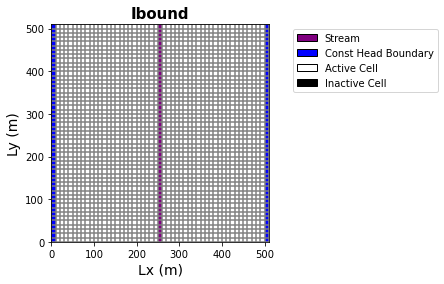

In [5]:
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

# Write MODFLOW input files and run the model

In [8]:
NTNA.write_input()

success, mfoutput = NTNA.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: NTNA.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/18 17:18:24

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.


Exception: MODFLOW did not terminate normally.

# Plot stream related results 

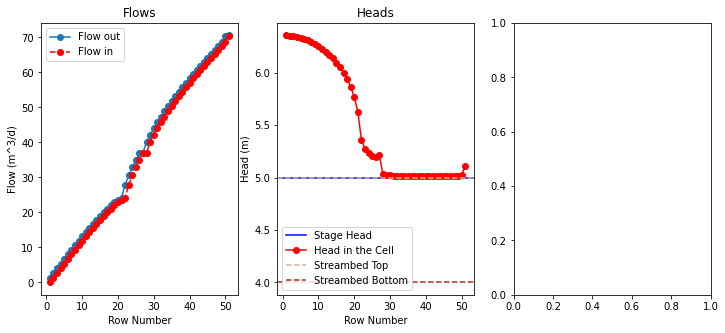

In [7]:
#####################################################################
# Reading budget and head output files
budgobj1 = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
#print(budgobj1.get_unique_record_names())
frf = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
leak = budgobj1.get_data(text='STREAM LEAKAGE', totim=1.0) 

str_outflow = budgobj1.get_data(text='STREAM FLOW OUT', totim=1.0) 
ch_flow = budgobj1.get_data(text='CONSTANT HEAD', totim=1.0) 

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
head = headobj.get_data(totim=1.0)

#####################################################################
#Preparing variables for plotting 
leakage = leak[0]
str_outflow = str_outflow[0]
str_inflow = str_outflow[:nrow-1]
str_inflow = str_inflow['q']
str_inflow = str_inflow.tolist()
str_inflow.insert(0, Flow_into_the_1st_reach) 
reach = np.arange(0,nrow,1) + 1
head_reach=[]
x_str = strspd[0][2]
x_str=int(x_str)
for i in range(nrow):
    head_reach.append(head[0][i][x_str])

#####################################################################
# Plotting reach wise water budget
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
#ax.set_aspect('equal')
ax1.set_title('Flows')
# ax1.plot(reach, leakage['q'], lw=3, label="Leaked to Aquifer", marker='o') 
ax1.plot(reach, str_outflow['q'], label="Flow out", marker='o') 
ax1.plot(reach, str_inflow, color='red', label="Flow in", linestyle='--', marker='o') 
# ax1.axhline(y=0,  color='black', linestyle='--')
ax1.set_xlabel('Row Number')
#ax1.set_xticks(reach)
ax1.set_ylabel('Flow (m^3/d)')
ax1.legend()

#####################################################################
# Plotting reach wise heads
ax2.set_title('Heads')
ax2.axhline(y=str_stage,  color='blue', label="Stage Head")
ax2.plot(reach, head_reach, color='red', label="Head in the Cell", marker='o') 
ax2.axhline(y=str_top,  color='tan', linestyle='--', label="Streambed Top")
ax2.axhline(y=str_bott,  color='brown', linestyle='--', label="Streambed Bottom")
ax2.set_xlabel('Row Number')
#ax2.set_xticks(reach)
ax2.set_ylabel('Head (m)')
ax2.legend()

# Plot head distribution

C:\Users\tento\Miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\tento\Miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


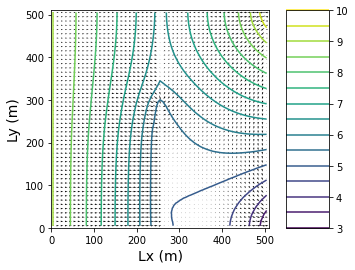

In [8]:
#####################################################################
# Plotting heads and flow arrows
plt.figure() 
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Steady-State Pumping, Flow(f^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)